In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 6

env: CUDA_VISIBLE_DEVICES=6


In [2]:
import sys

sys.path.insert(0, '../batchflow')
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd

from batchflow import Pipeline, B, V, I, M, C, plot
from batchflow.models.torch import TorchModel, VGGBlock
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from loader import ImagesDataset
from hooker import ForwardHooker

In [3]:
SEED = 11
rng = np.random.default_rng(SEED)

In [4]:
DATA_PATH = '../images'
SHAPE = (128, 128, 3)

dataset = ImagesDataset(path=DATA_PATH, encode_labels=True, normalize=True, resize_shape=SHAPE)
n_classes = dataset.label_encoder.classes_.size

dataset.split(shuffle=SEED)

100%|█████████████████████████████████████████████| 9/9 [00:16<00:00,  1.85s/it]


In [5]:
MODEL_PATH = '../models/vgg.torch'
model = TorchModel()
model.load(MODEL_PATH)
penultimate_module = model.model[1][-2]

## 

In [6]:
%%time

predict_template = (
    Pipeline()
    # prepare data
    .to_array(channels='first', dtype=np.float32)

    # initialize prediction and metrics containers
    .init_variables('images', 'labels', 'proba', 'predictions', 'metrics')
    
    # import trained model
    .import_model('model', model)
    
    # make predictions
    .predict_model(name='model', inputs=B('images'),
                   outputs=['predictions', 'predicted_proba'], save_to=[B('predictions'), B('proba')])
    
    # get penultimate layer activations
    .call(model.get_intermediate_activations, inputs=B('images'),
          layers=penultimate_module, save_to=B('activations'))
)

predict_pipeline_train = predict_template << dataset.train
train_batch = predict_pipeline_train.next_batch(dataset.train.size)

CPU times: user 747 ms, sys: 1.05 s, total: 1.8 s
Wall time: 8.65 s


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


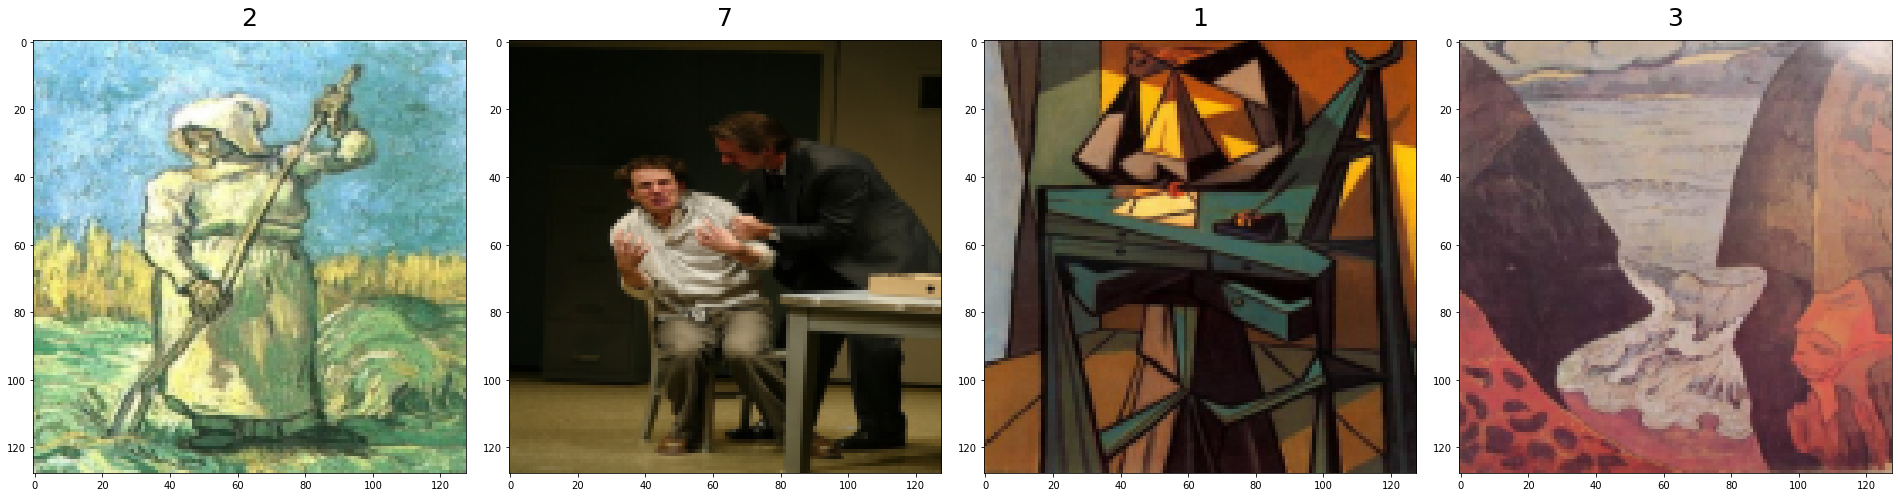

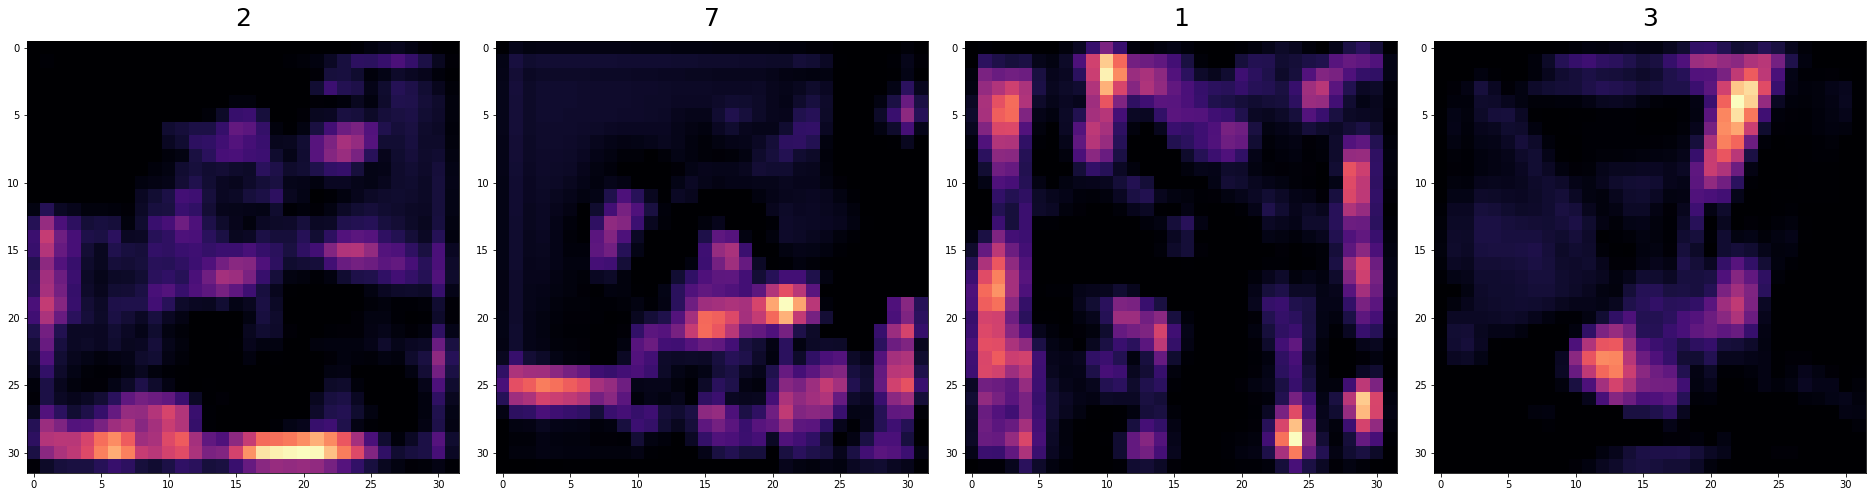

In [7]:
images = []
gradcams = []
labels = []

for index in rng.integers(0, dataset.train.size, 4):
    image = np.transpose(train_batch.images[index], (1, 2, 0))
    cam = model.get_gradcam(inputs=train_batch.images[index:index+1], layer=penultimate_module)
    images.append(image.reshape(*image.shape))
    gradcams.append(cam.reshape(*cam.shape, 1))
    label = train_batch.labels[index]
    labels.append(label)

plot(images, title=labels, combine='separate')
plot(gradcams, cmap='magma', title=labels, combine='separate')

In [8]:
%%time

pca = PCA(n_components=100, random_state=SEED)
train_features = train_batch.activations.reshape(dataset.train.size, -1)
train_features_reduced = pca.fit_transform(train_features)

CPU times: user 3min 46s, sys: 4min 59s, total: 8min 45s
Wall time: 12.7 s


In [9]:
%%time

clusterer = KMeans(n_clusters=n_classes, verbose=1, random_state=SEED)
train_clustered = clusterer.fit_predict(train_features_reduced)

Initialization complete
Iteration 0, inertia 144485808.0
Iteration 1, inertia 99650128.0
Iteration 2, inertia 98296088.0
Iteration 3, inertia 97980816.0
Iteration 4, inertia 97623504.0
Iteration 5, inertia 97212000.0
Iteration 6, inertia 96594488.0
Iteration 7, inertia 95525744.0
Iteration 8, inertia 95269232.0
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 157871840.0
Iteration 1, inertia 107579832.0
Iteration 2, inertia 104653896.0
Iteration 3, inertia 103488312.0
Iteration 4, inertia 102842640.0
Iteration 5, inertia 102608024.0
Iteration 6, inertia 102441976.0
Iteration 7, inertia 102333328.0
Iteration 8, inertia 102273992.0
Iteration 9, inertia 102187408.0
Iteration 10, inertia 102135544.0
Iteration 11, inertia 102061856.0
Iteration 12, inertia 101923488.0
Iteration 13, inertia 101862696.0
Iteration 14, inertia 101850384.0
Iteration 15, inertia 101838920.0
Converged at iteration 15: strict convergence.
Initialization complete
Iteration 0,

In [10]:
train_labels = train_batch.labels
train_predictions = np.argmax(train_batch.predictions, axis=1)

In [11]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [12]:
adjusted_rand_score(train_labels, train_predictions), adjusted_mutual_info_score(train_labels, train_predictions)

(1.0, 1.0000000000000002)

In [13]:
adjusted_rand_score(train_labels, train_clustered), adjusted_mutual_info_score(train_labels, train_clustered)

(1.0, 1.0000000000000002)

In [14]:
%%time

predict_pipeline_test = predict_template << dataset.test
test_batch = predict_pipeline_test.next_batch(dataset.test.size)

CPU times: user 157 ms, sys: 230 ms, total: 387 ms
Wall time: 2.11 s


In [15]:
%%time

test_features = test_batch.activations.reshape(dataset.test.size, -1)
test_features_reduced = pca.transform(test_features)

CPU times: user 6.85 s, sys: 11.3 s, total: 18.1 s
Wall time: 694 ms


In [16]:
%%time

test_clustered = clusterer.predict(test_features_reduced)

CPU times: user 12.5 ms, sys: 17.4 ms, total: 30 ms
Wall time: 954 µs


In [17]:
test_labels = test_batch.labels
test_predictions = np.argmax(test_batch.predictions, axis=1)

In [18]:
adjusted_rand_score(test_labels, test_clustered), adjusted_mutual_info_score(test_labels, test_clustered)

(0.41181874753950765, 0.41713203361026285)

In [19]:
for i in range(n_classes):
    i_count = np.bincount(test_labels[test_clustered == i], minlength=n_classes)
    print(f"{i}: {i_count} | max: {np.argmax(i_count)}")

0: [ 0  2  4  0 30  1  1  0] | max: 4
1: [1 1 0 0 0 0 8 1] | max: 6
2: [ 1  5 32  8  8  1  0  1] | max: 2
3: [ 2  2  1 23  1  1  1  0] | max: 3
4: [ 0  2  0  2  0  2  4 20] | max: 7
5: [ 2 58  7  6  1  0  4  2] | max: 1
6: [ 0  1  2  2  5 14  0  5] | max: 5
7: [6 1 0 1 0 0 1 0] | max: 0


In [20]:
renumerate = {
    0: 4,
    1: 6,
    2: 2,
    3: 3,
    4: 7,
    5: 1,
    6: 5,
    7: 0,
}

renumerated = np.empty_like(test_clustered)
for old, new in renumerate.items():
    renumerated[test_clustered == old] = new

In [21]:
from batchflow.models.metrics import ClassificationMetrics

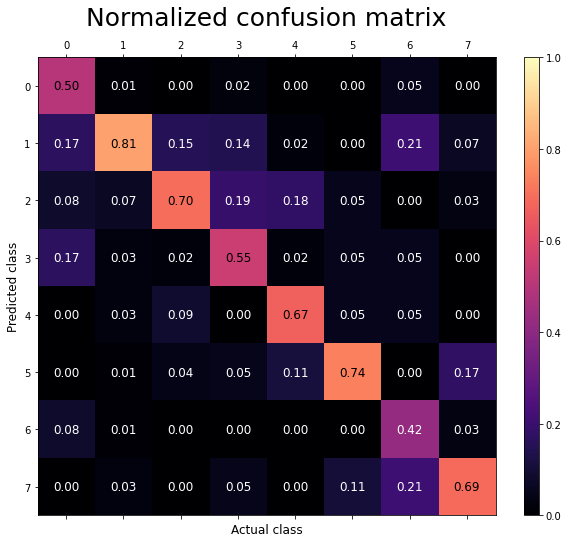

In [22]:
metrics = ClassificationMetrics(test_labels, renumerated, fmt='labels', num_classes=n_classes)
metrics.plot_confusion_matrix(normalize=True, vmin=0, vmax=1)

In [23]:
labels, counts = np.unique(dataset.labels[dataset.test.indices], return_counts=True)
shares = counts / counts.sum()

metrics_names = ['precision', 'recall']
metrics_dict = metrics.evaluate(metrics_names, multiclass=None)
metrics_df = pd.DataFrame({'names': dataset.label_encoder.classes_, 'counts': counts, 'shares': shares, **metrics_dict})

formatter = lambda value: f"{int(value * 100)}%"
metrics_df.style.background_gradient('RdYlGn', vmin=0, vmax=1, subset=metrics_names).format(formatter, subset=metrics_names)

,names,counts,shares,precision,recall
0,ArtDeco,12,0.042254,66%,50%
1,Cubism,72,0.253521,72%,80%
2,Impressionism,46,0.161972,57%,69%
3,Japonism,42,0.147887,74%,54%
4,Naturalism,45,0.158451,78%,66%
5,Rococo,19,0.066901,48%,73%
6,cartoon,19,0.066901,72%,42%
7,photo,29,0.102113,66%,68%


In [24]:
metrics_names = ['accuracy', 'f1_score']
metrics_values = [metrics.evaluate(metric_name) for metric_name in metrics_names]

metrics_df = pd.DataFrame(data=metrics_values, index=metrics_names)
metrics_df.T.style.background_gradient('RdYlGn', vmin=0, vmax=1).format(formatter)

,accuracy,f1_score
0,67%,65%


In [29]:
METRICS_PATH = '../metrics/knn_100.npy'
all_metrics = {**metrics_dict, **{key: value for key, value in zip(metrics_names, metrics_values)}}
np.save(METRICS_PATH, all_metrics)

In [28]:
# labels = dataset.label_encoder.inverse_transform(batch.labels)
# for cluster_num in range(n_classes):
#     cluster_images = batch.images[clustered == cluster_num]
#     cluster_images = list(cluster_images.transpose(0, 2, 3, 1))
#     cluster_true_labels = labels[clustered == cluster_num].tolist()
#     plot(cluster_images, title=cluster_true_labels, suptitle=f"cluster: {cluster_num}", suptitle_y=1, suptitle_size=30, combine='separate')